<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
C:\Users\oosun\AppData\Local\Temp\ipykernel_10332\3913729126.py:13: SyntaxWarning: invalid escape sequence '\d'
  df = pd.read_csv('..\data\Student_performance_data.csv', delimiter=",")


Accuracy: 0.7306889352818372

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.10      0.17        21
         1.0       0.58      0.52      0.55        54
         2.0       0.53      0.62      0.57        78
         3.0       0.63      0.45      0.52        83
         4.0       0.84      0.97      0.90       243

    accuracy                           0.73       479
   macro avg       0.72      0.53      0.54       479
weighted avg       0.73      0.73      0.71       479



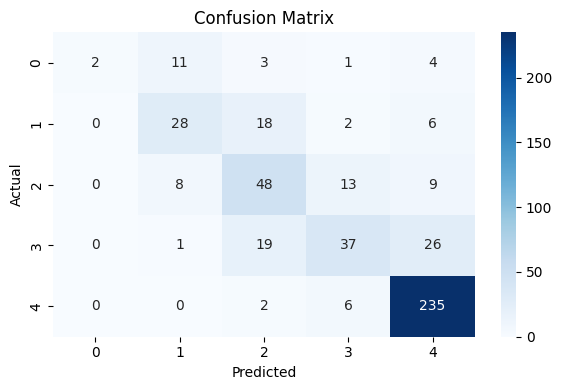

First 20 Predictions:

 First 20 Predictions:
 Actual  Predicted  Match
    2.0        2.0   True
    0.0        1.0  False
    4.0        4.0   True
    4.0        4.0   True
    3.0        2.0  False
    4.0        4.0   True
    4.0        4.0   True
    2.0        2.0   True
    3.0        4.0  False
    1.0        2.0  False
    4.0        4.0   True
    4.0        4.0   True
    4.0        4.0   True
    0.0        1.0  False
    0.0        4.0  False
    3.0        3.0   True
    4.0        4.0   True
    2.0        4.0  False
    3.0        2.0  False
    2.0        2.0   True


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

#Step 1: Import CSVs
df = pd.read_csv('..\data\Student_performance_data.csv', delimiter=",")

#Step 2: Separate features and target
X = df.drop(columns=["StudentID", "GradeClass", "GPA"])
y = df['GradeClass']

# Step 3: Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50, stratify=df['GradeClass'])

#Step 4: Feature sclaing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Step 5: Train Logistic Regression model
ln = LogisticRegression(solver='lbfgs', max_iter=100)
ln.fit(X_train_scaled, y_train)

#Setp 6: predictions
predictions = ln.predict(X_test_scaled)
predictions  #Returns GradeClass based on the columns provided

#Step 7: Evaluation
print("Accuracy:", accuracy_score(y_test, predictions))
print("\nClassification Report:\n", classification_report(y_test, predictions))

#Confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

#Step 8: Save the model as pkl file in artifacts

with open("../artifacts/regression_model.pkl", "wb") as file:
    pickle.dump(ln, file)
with open("../artifacts/regression_scaler.pkl", "wb") as file:
    pickle.dump(scaler, file)

#Step 9: Save predictions to CSV
comparison_df = X_test.copy()
comparison_df["Actual_GradeClass"] = y_test.values
comparison_df["Predicted_GradeClass"] = predictions

#Step 10: Show and save the prediction table

try:
    from IPython.display import display

    # Prepare DataFrame for display
    comparison_df = pd.DataFrame({"Actual": y_test.values,"Predicted": predictions})
    comparison_df["Match"] = comparison_df["Actual"] == comparison_df["Predicted"]

    def highlight_false_text(row):
        styles = []
        for col in row.index:
            if col == "Match" and row["Match"] == False:
                styles.append("color: red; background-color: black")
            else:
                styles.append("background-color: black; color: white")
        return styles

    print("First 20 Predictions:")
    display(comparison_df.head(20).style.apply(highlight_false_text, axis=1))

except Exception as e:
    print("\n First 20 Predictions:")
    print(comparison_df.head(20).to_string(index=False))


comparison_df.to_csv("../artifacts/regression_prediction.csv", index=False)
